# Projet : Conversion Rate Challenge 🥇🥈🥉

## Import des modules

In [ ]:
import time
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    classification_report,
)

import optuna

import matplotlib.pyplot as plt
import seaborn as sns

## Préparation des données

In [2]:
# #####################################################################
# Loading dataset
conversion_train_raw_df = pd.read_csv('./data/conversion_data_train.csv')
print('Train dataset :', conversion_train_raw_df.shape)

# #####################################################################
# Features groups
target_feature = "converted"
numerical_features = ["age", "total_pages_visited"]
categorical_features = ["country", "new_user", "source"]

print(f"{'Target':<20}: {target_feature}")
print(f"{'Numerical features':<20}: {numerical_features}")
print(f"{'Categorical features':<20}: {categorical_features}")

# #####################################################################
# Model Preprocessor

# Numerical features
numerical_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

# Categorical features
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop="first")),
    ]
)

# Build features prepocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# #####################################################################
# Data preprocessing
train_df = conversion_train_raw_df[conversion_train_raw_df["age"] < 90]

# Divide dataset Train set & Test set
X_df = train_df.drop(columns=target_feature)
y_df = train_df[target_feature]

print("Dividing into train and test sets...")
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=75, stratify=y_df)

print("...Done.")
print()

# Preprocess the train & test datasets
X_train = preprocessor.fit_transform(X_train_df)
X_test = preprocessor.transform(X_test_df)

y_train = y_train_df.tolist()
y_test = y_test_df.tolist()

print(f"X_train {X_train.shape} and X_test {X_test.shape} are ready for model training!")

Train dataset : (284580, 6)
Target              : converted
Numerical features  : ['age', 'total_pages_visited']
Categorical features: ['country', 'new_user', 'source']
Dividing into train and test sets...
...Done.

X_train (227662, 8) and X_test (56916, 8) are ready for model training!


## Fonctions d'évaluation

In [95]:
def evaluate_model(classifier, X_train, y_train, X_test, y_test, classifier_name=None, print_details=False, treshold=None):
    if treshold:
        y_train_pred_proba = classifier.predict_proba(X_train)[:, 1]
        y_train_pred = (y_train_pred_proba >= treshold).astype(int)

        y_test_pred_proba = classifier.predict_proba(X_test)[:, 1]
        y_test_pred = (y_test_pred_proba >= treshold).astype(int)
    else:
        # Use default tresholds
        y_train_pred = classifier.predict(X_train)
        y_test_pred = classifier.predict(X_test)

    metrics = {
        "classifier_name": classifier_name or type(classifier).__name__,
        "f1_train": f1_score(y_train, y_train_pred),
        "precision_train": precision_score(y_train,  y_train_pred),
        "recall_train": recall_score(y_train,  y_train_pred),
        "f1_test": f1_score(y_test, y_test_pred),
        "precision_test": precision_score(y_test,  y_test_pred),
        "recall_score": recall_score(y_test,  y_test_pred),
        
    }

    # Affichage des métriques
    print(f"\n📊 Évaluation pour {metrics['classifier_name']}")
    for key, value in metrics.items():
        if key != "classifier_name":
            print(f"{key}: {value:.6f}")
            
    if print_details:
        print("Confusion matrix on train set : ")
        print(confusion_matrix(y_train, y_train_pred))
        print()
        print("Confusion matrix on test set : ")
        print(confusion_matrix(y_test, y_test_pred))
        print()
        print("classification report:")
        print(classification_report(y_true=y_train, y_pred=y_train_pred))
        
        _, ax = plt.subplots(2, 2, figsize=(15,10))  # Get subplot from matplotlib

        # Visualize confusion matrices
        disp = ConfusionMatrixDisplay.from_estimator(
            classifier, X_train, y_train, ax=ax[0, 0]
        )
        disp.ax_.set_title('Confusion Matrix on Train set')

        disp = ConfusionMatrixDisplay.from_estimator(
            classifier, X_test, y_test, ax=ax[0, 1]
        ) 
        disp.ax_.set_title('Confusion Matrix on Test set')

        # Visualize ROC curves
        disp = RocCurveDisplay.from_estimator(
            classifier, X_train, y_train, ax=ax[1,0]
        ) 
        disp.ax_.set_title('ROC Curve on Train set')

        disp = RocCurveDisplay.from_estimator(
            classifier, X_test, y_test, ax=ax[1,1]
        ) 
        disp.ax_.set_title('ROC Curve on Test set')

        plt.show()
    
    return metrics

## Rappel: modèle de départ

Le modèle que l'on souhaite améliorer et ses performances.

Train model...
...Done.

📊 Évaluation pour base_classifier
f1_train: 0.762798
precision_train: 0.857386
recall_train: 0.687006
f1_test: 0.762424
precision_test: 0.859290
recall_score: 0.685185
Confusion matrix on train set : 
[[219481    839]
 [  2298   5044]]

Confusion matrix on test set : 
[[54874   206]
 [  578  1258]]

classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.86      0.69      0.76      7342

    accuracy                           0.99    227662
   macro avg       0.92      0.84      0.88    227662
weighted avg       0.99      0.99      0.99    227662



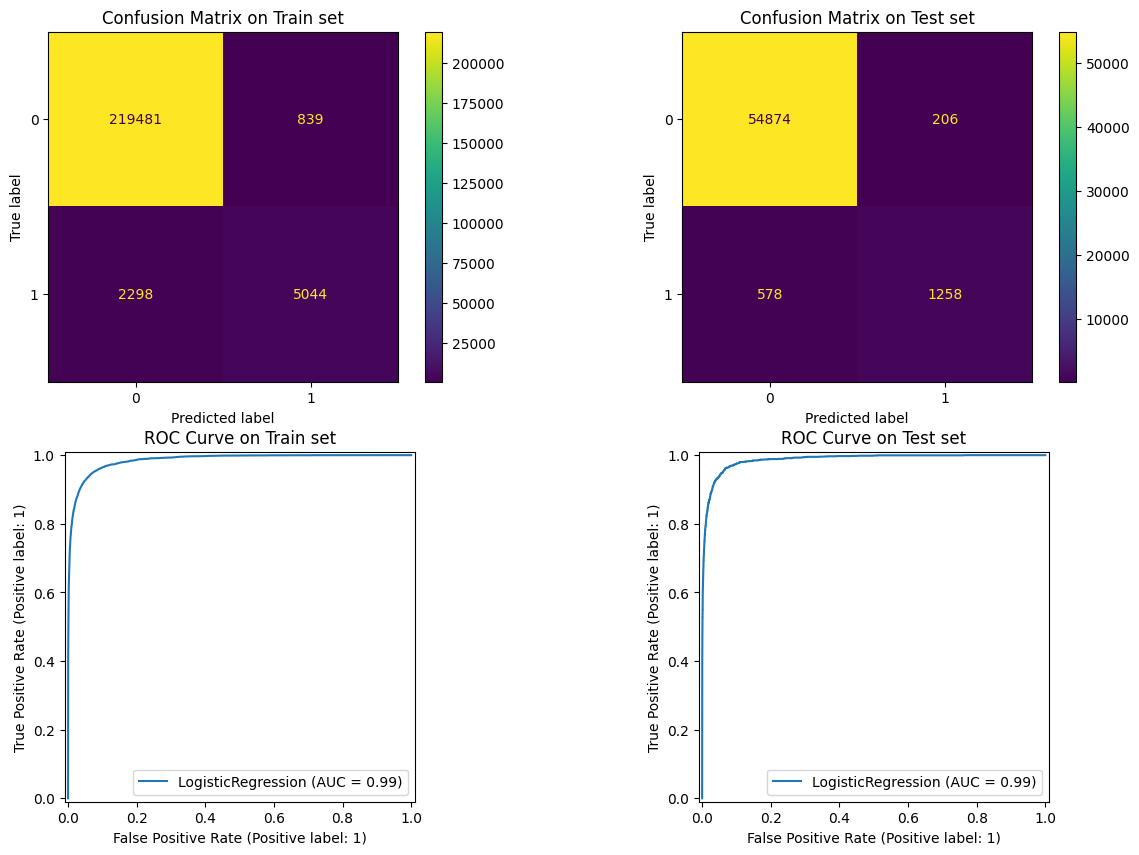

In [84]:
print("Train model...")
base_classifier = LogisticRegression()
base_classifier.fit(X_train, y_train)
print("...Done.")

base_classifier_metrics = evaluate_model(base_classifier, X_train, y_train, X_test, y_test, classifier_name="base_classifier", print_details=True)

In [5]:
base_classifier_metrics

{'classifier_name': 'base_classifier',
 'f1_train': 0.7627977315689981,
 'precision_train': 0.8573856875743668,
 'recall_train': 0.6870062653228003,
 'f1_test': 0.7624242424242424,
 'precision_test': 0.8592896174863388,
 'recall_score': 0.6851851851851852}

## Amélioration du modèle

Aprés avoir fait une version de base, améliorons ce modèle en utilisant les techniques connues:
- optimisation des hyperparamètres
- feature engineering
- changement de seuil

### Optimisation des hyperparamètres

In [52]:
def optimize_with_optuna(X_train_arg, y_train_arg): #, X_test_arg, y_test_arg
    def logreg_objective(trial):
        lr_max_iter = trial.suggest_int("max_iter", 50, 500, log=False)
        lr_c = trial.suggest_float("lr_c", 0.1, 250, log=True)
        
        lr_solver = trial.suggest_categorical("lr_solver", ["lbfgs"])
        lr_penalty = trial.suggest_categorical("lr_penalty", ["l2"])
        
        lr_class_weight = trial.suggest_categorical("lr_class_weight", ["balanced", None])
        
        clf =  LogisticRegression(max_iter=lr_max_iter, C=lr_c, solver=lr_solver, penalty=lr_penalty, class_weight=lr_class_weight)

        scores = cross_val_score(clf, X_train_arg, y_train_arg, cv=5, scoring='f1', n_jobs=-1)
        score = scores.mean()

        return score
        
    logreg_study = optuna.create_study(direction='maximize')
    logreg_study.optimize(logreg_objective, n_trials=200)
    
    best_p = optuna_study.best_trial.params

    best_estimator = LogisticRegression(random_state=42, max_iter=best_p.get("max_iter"), solver="lbfgs", penalty="l2", class_weight=best_p.get("lr_class_weight"), C=best_p.get("lr_c"))
 
    return best_estimator, logreg_study


In [53]:
best_classifier, optuna_study = optimize_with_optuna(X_train, y_train)
best_classifier

[I 2025-05-25 15:39:09,676] A new study created in memory with name: no-name-6ec08b0b-90b6-44a6-b5ea-1382bf2e6626


[I 2025-05-25 15:39:11,948] Trial 0 finished with value: 0.7625440272863971 and parameters: {'max_iter': 83, 'lr_c': 0.7915026417135113, 'lr_solver': 'lbfgs', 'lr_penalty': 'l2', 'lr_class_weight': None}. Best is trial 0 with value: 0.7625440272863971.
[I 2025-05-25 15:39:13,605] Trial 1 finished with value: 0.7623311328321875 and parameters: {'max_iter': 166, 'lr_c': 18.98399333019686, 'lr_solver': 'lbfgs', 'lr_penalty': 'l2', 'lr_class_weight': None}. Best is trial 0 with value: 0.7625440272863971.
[I 2025-05-25 15:39:15,272] Trial 2 finished with value: 0.5048818672320502 and parameters: {'max_iter': 144, 'lr_c': 34.44174718625347, 'lr_solver': 'lbfgs', 'lr_penalty': 'l2', 'lr_class_weight': 'balanced'}. Best is trial 0 with value: 0.7625440272863971.
[I 2025-05-25 15:39:16,906] Trial 3 finished with value: 0.762204753815977 and parameters: {'max_iter': 317, 'lr_c': 1.6882637207235467, 'lr_solver': 'lbfgs', 'lr_penalty': 'l2', 'lr_class_weight': None}. Best is trial 0 with value: 0.

LogisticRegression(C=0.9121265462136994, max_iter=811, random_state=42)

In [54]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(optuna_study)


📊 Évaluation pour best_classifier
f1_train: 0.762740
precision_train: 0.857240
recall_train: 0.687006
f1_test: 0.761962
precision_test: 0.858117
recall_score: 0.685185
Confusion matrix on train set : 
[[219480    840]
 [  2298   5044]]

Confusion matrix on test set : 
[[54872   208]
 [  578  1258]]

classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.86      0.69      0.76      7342

    accuracy                           0.99    227662
   macro avg       0.92      0.84      0.88    227662
weighted avg       0.99      0.99      0.99    227662



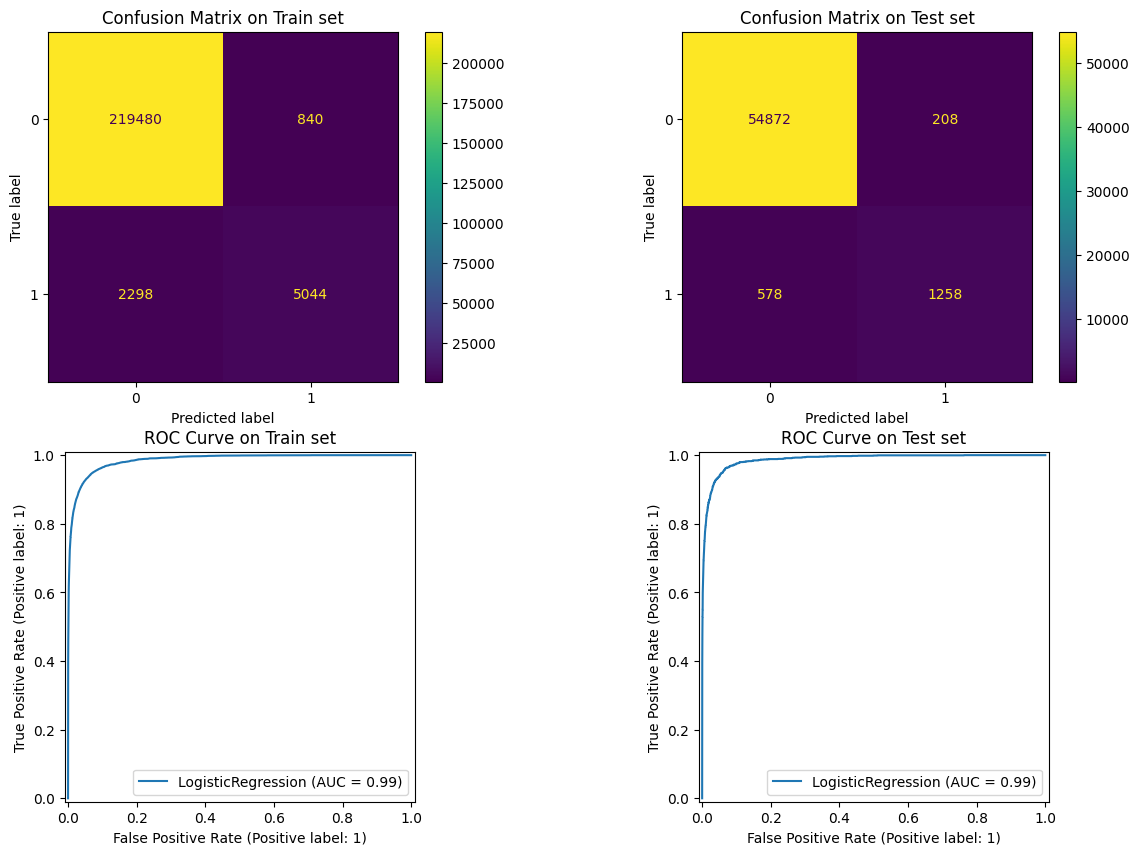

{'classifier_name': 'best_classifier',
 'f1_train': 0.7627400574625737,
 'precision_train': 0.8572399728076139,
 'recall_train': 0.6870062653228003,
 'f1_test': 0.761962447001817,
 'precision_test': 0.8581173260572987,
 'recall_score': 0.6851851851851852}

In [83]:
best_classifier.fit(X_train, y_train)

best_classifier_metrics = evaluate_model(best_classifier, X_train, y_train, X_test, y_test, classifier_name="best_classifier", print_details=True)

best_classifier_metrics

No real improvements.

### Feature engineering

Let see if adding some features may help!

In [90]:
def show_features_impact(preprocessor_arg, estimator_arg):
    # Extracting feature names from estimator
    all_feature_names = []
    for name, pipeline, features_list in preprocessor_arg.transformers_: # loop over pipelines
        if name == 'num': # if pipeline is for numeric variables
            features = features_list # just get the names of columns to which it has been applied
        else: # if pipeline is for categorical variables
            features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
        all_feature_names.extend(features) # concatenate features names

    # find the coeffs from the model
    coefficients = estimator_arg.coef_[0]

    features_coeff_df = pd.DataFrame({
        "feature": all_feature_names,
        "coefficient": coefficients
    })

    # Create a dataframe ordered by abs(coefficient)
    features_coeff_df = features_coeff_df.reindex(features_coeff_df["coefficient"].abs().sort_values(ascending=False).index)
    
    h = len(all_feature_names) / 5
    
    if h < 5:
        h = 5
    
    plt.figure(figsize=(10, h))
    sns.barplot(x="coefficient", y="feature", data=features_coeff_df)
    plt.title("Features Importance")
    plt.show()

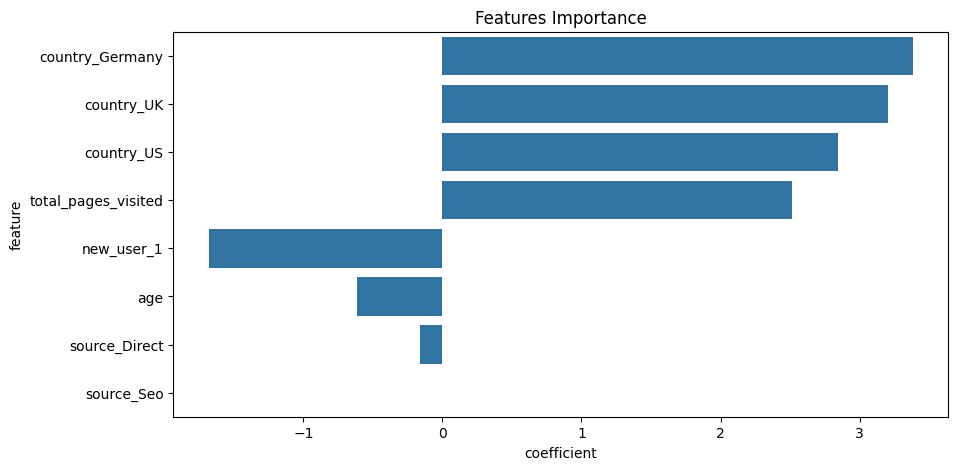

In [91]:
show_features_impact(preprocessor, base_classifier)

In [ ]:

X_train = preprocessor.fit_transform(X_train_df)

print("Train model...")
base_classifier = LogisticRegression()
base_classifier.fit(X_train, y_train)
print("...Done.")

base_classifier_metrics = evaluate_model(base_classifier, X_train, y_train, X_test, y_test, classifier_name="base_classifier", print_details=True)

In [60]:
import preprocessing as pp

q_df = pp.discretize_quantiles(X_train_df, columns=['age', 'total_pages_visited'], drop_first_dummy=True)
q_df

,country,age,new_user,source,total_pages_visited,age_bin_q1_q2,age_bin_q2_q3,age_bin_q3_q4,total_pages_visited_bin_q1_q2,total_pages_visited_bin_q2_q3,total_pages_visited_bin_q3_q4
229373,Germany,20,1,Ads,6,0,0,0,0,1,0
176579,UK,41,0,Direct,4,0,0,1,0,1,0
181608,China,21,1,Seo,10,0,0,0,0,0,1
104562,Germany,25,1,Seo,1,1,0,0,0,0,0
214951,US,39,1,Seo,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
196460,US,25,1,Direct,2,1,0,0,1,0,0
24817,China,28,0,Seo,1,1,0,0,0,0,0
259619,US,36,1,Seo,2,0,0,1,1,0,0
37023,UK,22,0,Direct,3,0,0,0,1,0,0


In [ ]:
QUANTILE_0 = 0.0
QUANTILE_1 = 0.25
QUANTILE_2 = 0.5
QUANTILE_3 = 0.75
QUANTILE_4 = 1.0
DEFAULT_QUANTILES_REF = [QUANTILE_0, QUANTILE_1, QUANTILE_2, QUANTILE_3, QUANTILE_4]

def discretize_quantiles(df: pd.DataFrame, columns: list[str], drop_first_dummy: bool=True, quantiles: list[float]=DEFAULT_QUANTILES_REF) -> pd.DataFrame:
    l_df = df.copy()

    for column in columns:
        q_values = df[column].quantile(quantiles)

        # quantiles_labels = [f"{prefix}_{q}" for q in ['q0_q1', 'q1_q2', 'q2_q3', 'q3_q4']]
        bin_column_name = column + '_bin'

        q_bin_names = [f'q{i}_q{i+1}' for i in range(len(quantiles)-1)]

        q_bins = [-float('inf')]
        q_bins += [q_values[quantiles[i]] for i in range(1, len(quantiles)-1)]
        q_bins.append(float('inf'))

        #quantiles_labels = ['q0_q1', 'q1_q2', 'q2_q3', 'q3_q4']
        #bins=[-float('inf'), q_values[QUANTILE_1], q_values[QUANTILE_2], q_values[QUANTILE_3], float('inf')]

        l_df[bin_column_name] = pd.cut(l_df[column], bins=q_bins, labels=q_bin_names, right=False)
        l_df = pd.get_dummies(l_df, columns=[bin_column_name], drop_first=drop_first_dummy, dtype=int)

    return l_df

# Add some features to the dataset
# - polynomial
# - discretization
def extend_features(x_df_arg):

    # Discretize numeric features per quartiles    
    x_df = discretize_quantiles(x_df_arg, columns=['age', 'total_pages_visited'], drop_first_dummy=True)
  
    # Add some polynomial features
    x_df["age_2"] = x_df["age"]**2
    x_df["age_3"] = x_df["age"]**3
    
    x_df["total_pages_visited_2"] = x_df["total_pages_visited"]**2
    x_df["total_pages_visited_3"] = x_df["total_pages_visited"]**3
    
    # Create features combinations
    # create masks
    mask1 = x_df["country"] == "US"
    mask2 = x_df["country"] == "UK"
    mask3 = x_df["country"] == "Germany"
    mask4 = x_df["country"] == "China"

    mask5 = x_df["age"] < 26
    mask6 = (x_df["age"] >= 26) & (x_df["age"] <= 46)
    mask7 = x_df["age"] > 46

    mask8 = x_df["new_user"] == "No"
    mask9 = x_df["new_user"] == "Yes"

    mask10 = x_df["total_pages_visited"] < 5
    mask11 = (x_df["total_pages_visited"] >= 5) & (x_df["total_pages_visited"] <= 12)
    mask12 = x_df["total_pages_visited"] > 12

    mask13 = x_df["source"] == "Ads"
    mask14 = x_df["source"] == "Seo"
    mask15 = x_df["source"] == "Direct"

    # create dataframe containing mask names
    mask_ids = ["mask1", "mask2", "mask3", "mask4", "mask5", "mask6", "mask7", "mask8", "mask9", "mask10", "mask11",
        "mask12", "mask13", "mask14", "mask15"]
    mask_names = ["US", "UK", "Germany", "China", "young", "midage", "old", "old_user", "new_user", "few", "mid", 
        "many", "Ads", "Seo", "Direct"]

    mask_ids = pd.DataFrame(mask_ids, columns = ["mask"])
    mask_names = pd.DataFrame(mask_names, columns = ["name"])
    masks = pd.concat([mask_ids, mask_names], axis = 1)

    # create combinations of features
    for i in range(0, masks.shape[0]):

        mask_first = locals()[masks.loc[i,"mask"]]
        
        for j in range(i, masks.shape[0]):

            mask_second = locals()[masks.loc[j,"mask"]]
            
            mask_current = mask_first | mask_second
            feature_name = masks.loc[i,"name"] + "_or_" + masks.loc[j,"name"]

            feature_current = pd.Series("no", index = x_df.index, name = feature_name)
            feature_current[mask_current] = "yes"
            x_df = pd.concat([x_df, feature_current], axis = 1)

    return x_df


In [66]:
X_train_ext_df = extend_features(X_train_df)
X_train_ext_df

,country,age,new_user,source,total_pages_visited,age_bin_q1_q2,age_bin_q2_q3,age_bin_q3_q4,total_pages_visited_bin_q1_q2,total_pages_visited_bin_q2_q3,...,many_or_many,many_or_Ads,many_or_Seo,many_or_Direct,Ads_or_Ads,Ads_or_Seo,Ads_or_Direct,Seo_or_Seo,Seo_or_Direct,Direct_or_Direct
229373,Germany,20,1,Ads,6,0,0,0,0,1,...,no,yes,no,no,yes,yes,yes,no,no,no
176579,UK,41,0,Direct,4,0,0,1,0,1,...,no,no,no,yes,no,no,yes,no,yes,yes
181608,China,21,1,Seo,10,0,0,0,0,0,...,no,no,yes,no,no,yes,no,yes,yes,no
104562,Germany,25,1,Seo,1,1,0,0,0,0,...,no,no,yes,no,no,yes,no,yes,yes,no
214951,US,39,1,Seo,1,0,0,1,0,0,...,no,no,yes,no,no,yes,no,yes,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196460,US,25,1,Direct,2,1,0,0,1,0,...,no,no,no,yes,no,no,yes,no,yes,yes
24817,China,28,0,Seo,1,1,0,0,0,0,...,no,no,yes,no,no,yes,no,yes,yes,no
259619,US,36,1,Seo,2,0,0,1,1,0,...,no,no,yes,no,no,yes,no,yes,yes,no
37023,UK,22,0,Direct,3,0,0,0,1,0,...,no,no,no,yes,no,no,yes,no,yes,yes


In [67]:
print('Automatically detect names of numeric/categorical explanatory variables:')

ext_numerical_features = X_train_ext_df.select_dtypes(include=[np.number]).columns.tolist()
ext_categorical_features = X_train_ext_df.select_dtypes(include='object').columns.tolist()        

print('Numerical features: ', ext_numerical_features)
print('Categorical features: ', ext_categorical_features)

Automatically detect names of numeric/categorical explanatory variables:
Numerical features:  ['age', 'new_user', 'total_pages_visited', 'age_bin_q1_q2', 'age_bin_q2_q3', 'age_bin_q3_q4', 'total_pages_visited_bin_q1_q2', 'total_pages_visited_bin_q2_q3', 'total_pages_visited_bin_q3_q4', 'age_2', 'age_3', 'total_pages_visited_2', 'total_pages_visited_3']
Categorical features:  ['country', 'source', 'US_or_US', 'US_or_UK', 'US_or_Germany', 'US_or_China', 'US_or_young', 'US_or_midage', 'US_or_old', 'US_or_old_user', 'US_or_new_user', 'US_or_few', 'US_or_mid', 'US_or_many', 'US_or_Ads', 'US_or_Seo', 'US_or_Direct', 'UK_or_UK', 'UK_or_Germany', 'UK_or_China', 'UK_or_young', 'UK_or_midage', 'UK_or_old', 'UK_or_old_user', 'UK_or_new_user', 'UK_or_few', 'UK_or_mid', 'UK_or_many', 'UK_or_Ads', 'UK_or_Seo', 'UK_or_Direct', 'Germany_or_Germany', 'Germany_or_China', 'Germany_or_young', 'Germany_or_midage', 'Germany_or_old', 'Germany_or_old_user', 'Germany_or_new_user', 'Germany_or_few', 'Germany_or

In [68]:
# #####################################################################
# Model Preprocessor
ext_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, ext_numerical_features),
        ("cat", categorical_transformer, ext_categorical_features),
    ]
)

In [70]:
X_train_ext = ext_preprocessor.fit_transform(X_train_ext_df)

print("Train model...")
base_classifier_ext = LogisticRegression()
base_classifier_ext.fit(X_train_ext, y_train)
print("...Done.")

Train model...
...Done.



📊 Évaluation pour base_classifier_ext
f1_train: 0.761638
precision_train: 0.857216
recall_train: 0.685236
f1_test: 0.760949
precision_test: 0.861570
recall_score: 0.681373
Confusion matrix on train set : 
[[219482    838]
 [  2311   5031]]

Confusion matrix on test set : 
[[54879   201]
 [  585  1251]]

classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.86      0.69      0.76      7342

    accuracy                           0.99    227662
   macro avg       0.92      0.84      0.88    227662
weighted avg       0.99      0.99      0.99    227662



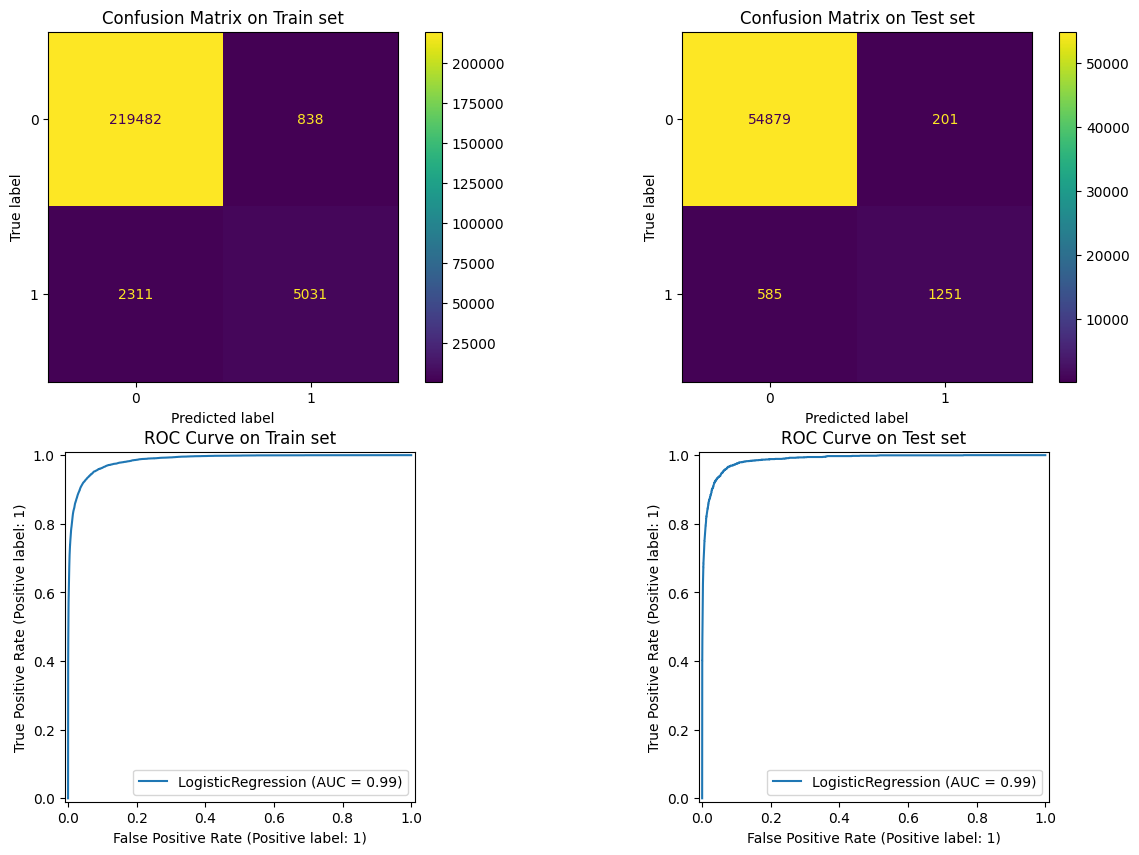

In [72]:
X_test_ext_df = extend_features(X_test_df)
X_test_ext = ext_preprocessor.transform(X_test_ext_df)

base_classifier_metrics = evaluate_model(base_classifier_ext, X_train_ext, y_train, X_test_ext, y_test, classifier_name="base_classifier_ext", print_details=True)


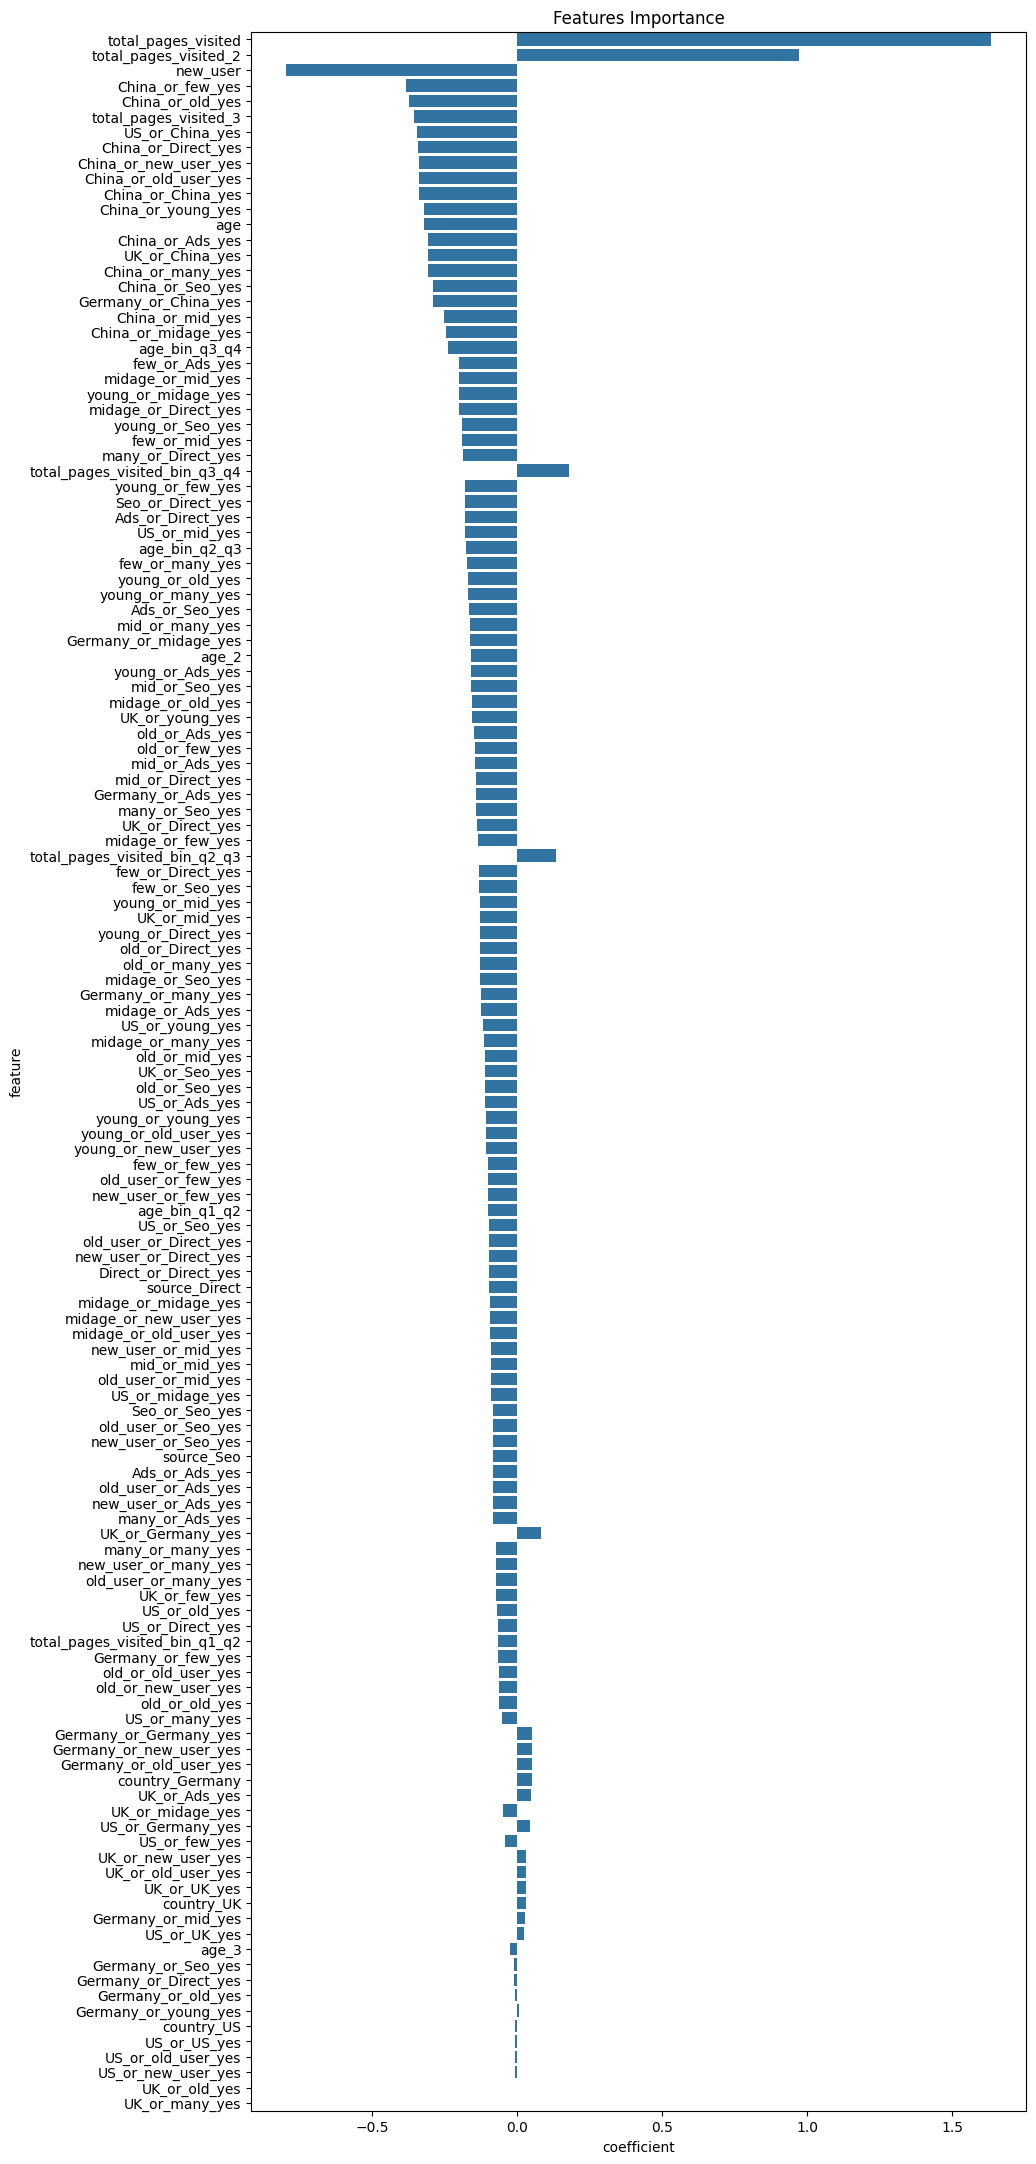

In [92]:
show_features_impact(ext_preprocessor, base_classifier_ext)

Pas d'amélioration notable.

### Recherche du seuil optimal

Le dernier paramètre par lequel on peut influer sur les performance du modèle!

100
F1 score max value : 0.771870
Optimal threshold  : 0.4


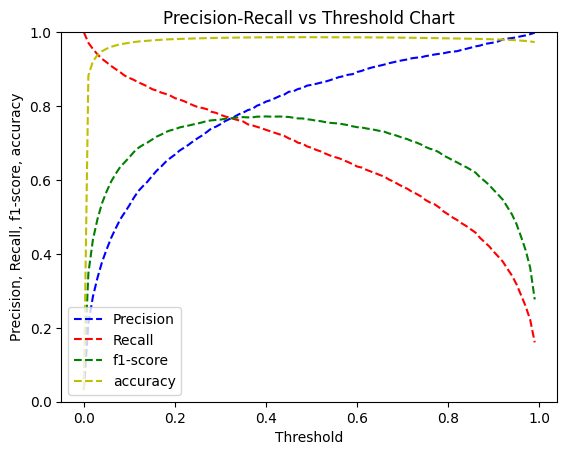

In [ ]:
y_preds_proba = base_classifier.predict_proba(X_train)[:, 1]

# 1000: thresholds = np.arange(0.0, 1.0, 0.001)
thresholds = np.arange(0.0, 1.0, 0.01)
precisions = []
recalls = []
f1_scores = []
accuracy_scores = []

#Y_pred_all = best_estimator.predict(X_train_all)
print(len(thresholds))

for threshold in thresholds:
   y_preds = (y_preds_proba  >= threshold).astype(int)

   precisions.append(precision_score(y_train, y_preds))
   recalls.append(recall_score(y_train, y_preds))
   f1_scores.append(f1_score(y_train, y_preds))
   accuracy_scores.append((y_preds == y_train).mean())

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precisions, "b--", label="Precision")
plt.plot(thresholds, recalls, "r--", label="Recall")
plt.plot(thresholds, f1_scores, "g--", label="f1-score")
plt.plot(thresholds, accuracy_scores, "y--", label="accuracy")
plt.ylabel("Precision, Recall, f1-score, accuracy")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

print(f"F1 score max value : {max(f1_scores):.6f}")
max_index = f1_scores.index(max(f1_scores))
print(f"Optimal threshold  : {thresholds[max_index]}")

computed_best_treshold = thresholds[max_index]


📊 Évaluation pour base_classifier_ext
f1_train: 0.771870
precision_train: 0.812030
recall_train: 0.735494
f1_test: 0.765688
precision_test: 0.811966
recall_score: 0.724401
Confusion matrix on train set : 
[[219070   1250]
 [  1942   5400]]

Confusion matrix on test set : 
[[54772   308]
 [  506  1330]]

classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    220320
           1       0.81      0.74      0.77      7342

    accuracy                           0.99    227662
   macro avg       0.90      0.86      0.88    227662
weighted avg       0.99      0.99      0.99    227662



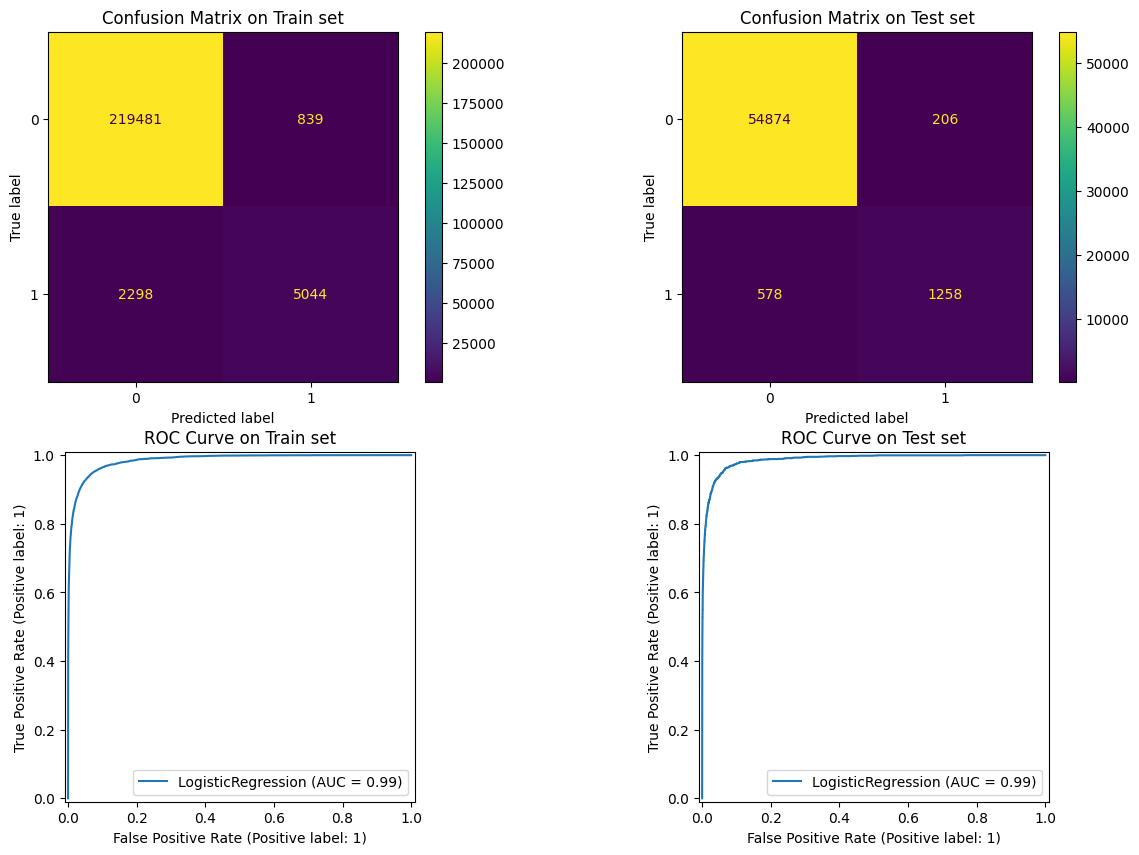

In [96]:
custom_base_classifier_metrics = evaluate_model(base_classifier, X_train, y_train, X_test, y_test, classifier_name="base_classifier_ext", print_details=True, treshold=0.4)

## Challenge

Au final, rien n'a vraiment améliorer le modèle hormis le seuil. Donc le challenge sera tenté avec cette simple optimisation!

In [97]:
# Train model
print("Train model...")
challenge_classifier = LogisticRegression()
challenge_classifier.fit(X_train, y_train)
print("...Done.")

# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train, X_test, axis=0)
Y = np.append(y_train, y_test)

challenge_classifier.fit(X, Y)

Train model...
...Done.


LogisticRegression()

In [98]:
# Read data without labels
conversion_challenge_test_raw_df = pd.read_csv('./data/conversion_data_test.csv')
print('Test (Challenge / without labels) dataset :', conversion_challenge_test_raw_df.shape)

# Apply same outliers treshold as train
challenge_test_df = conversion_challenge_test_raw_df[conversion_challenge_test_raw_df["age"] < 90]

# Preprocess the test dataset
X_challenge_test = preprocessor.transform(challenge_test_df)

# Predict
y_challenge_test_preds_proba = challenge_classifier.predict_proba(X_challenge_test)[:, 1]
y_challenge_test_preds = (y_challenge_test_preds_proba >= 0.4).astype(int)

data = {
    'converted': y_challenge_test_preds
}

y_challenge_test_predictions = pd.DataFrame(columns=['converted'], data=data)

# Save the predictions in order to submit for the challenge
predictions_output_csv_path = f"data/predictions/conversion_data_test_predictions_CGUILLOT-v3-{time.strftime('%Y%m%d-%H%M%S')}.csv"
Path(predictions_output_csv_path).parent.mkdir(parents=True, exist_ok=True)
y_challenge_test_predictions.to_csv(predictions_output_csv_path, index=False)
print(f"Challenge predictions save at {predictions_output_csv_path}")

Test (Challenge / without labels) dataset : (31620, 5)
Challenge predictions save at data/predictions/conversion_data_test_predictions_CGUILLOT-v3-20250525-162058.csv


In [99]:
# Rebuild challenge score
conversion_challenge_test_raw_labels_df = pd.read_csv('./data/secret/conversion_data_test_labels.csv')

challenge_f1 = f1_score(conversion_challenge_test_raw_labels_df, y_challenge_test_preds)
challenge_precision = precision_score(conversion_challenge_test_raw_labels_df, y_challenge_test_preds)
challenge_recall = recall_score(conversion_challenge_test_raw_labels_df, y_challenge_test_preds)

print(f"{'Challenge f1-score':<20}: {challenge_f1:.6f}")
print(f"{'Challenge precision':<20}: {challenge_precision:.6f}")
print(f"{'Challenge recall':<20}: {challenge_recall:.6f}")

Challenge f1-score  : 0.764948
Challenge precision : 0.806522
Challenge recall    : 0.727451


### Leaderboard

Avec cette optimisation, 3ème place.

![podium.png](./assets/podium.png)

# Conclusion

Au final, le modèle LinearRegression s'est montré plutôt bon pour un cout d'entrainement modeste.

Il serait surement interessant de pousser plus loin les tests de XGBoost, afin d'infirmer ou non le choix fait sur la base des premiers tests.